In [1]:
import pydicom
import numpy as np
import skimage
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import os

In [2]:
def read_dicom_to_hu(dcm_path):
    
    # reading DICOM and presenting image array in HU
    
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array.astype(np.int16)
    intercept = dcm.RescaleIntercept
    slope = dcm.RescaleSlope

    output = slope * img.astype(np.float64)
    output = output.astype(np.int16)
    output += np.int16(intercept)
    
    return output

In [3]:
def masking(img, w, l):
    
    # creating mask for corresponding window
    
    hw = w/2
    th_low = l-hw
    th_up = l+hw
    return ((img>th_low)*(img<th_up))

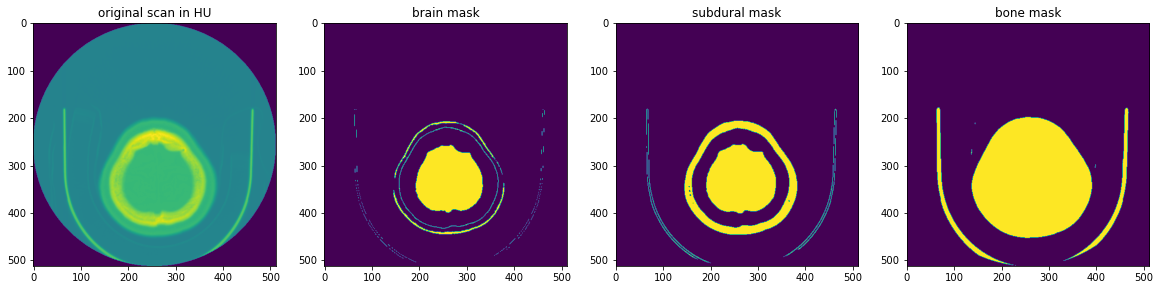

In [5]:
# check masks for different windows

img_hu = read_dicom_to_hu(r"C:\Users\e.lavrova\Desktop\DCM_noisy_Images\ID_000a8710b.dcm")

plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.imshow(img_hu)
plt.title('original scan in HU')

plt.subplot(1, 4, 2)
plt.imshow(masking(img_hu, 80, 40))
plt.title('brain mask')

plt.subplot(1, 4, 3)
plt.imshow(masking(img_hu, 300, 75))
plt.title('subdural mask')

plt.subplot(1, 4, 4)
plt.imshow(masking(img_hu, 2800, 600))
plt.title('bone mask')

plt.show()

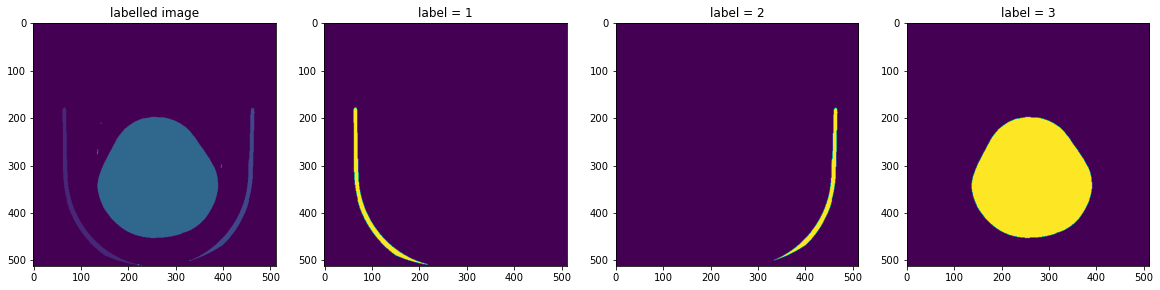

In [7]:
# take bone mask, separate morphologically individual areas, pick the biggest one (head), 
# the rest (head holder) are to be dropped

label_image = label(masking(img_hu, 2800, 600))

plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.imshow(label_image)
plt.title('labelled image')

plt.subplot(1, 4, 2)
plt.imshow(label_image == 1)
plt.title('label = 1')

plt.subplot(1, 4, 3)
plt.imshow(label_image == 2)
plt.title('label = 2')

plt.subplot(1, 4, 4)
plt.imshow(label_image == 3)
plt.title('label = 3')
plt.show()

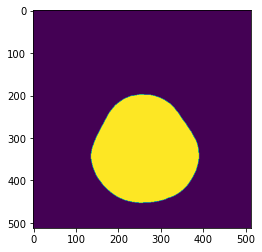

In [8]:
connected_regions = regionprops(label_image)

# in here selecting the biggest region
brainmask = (label_image==(1+np.argmax([i.area for i in connected_regions]))).astype(int) 

plt.imshow(brainmask)
plt.show()

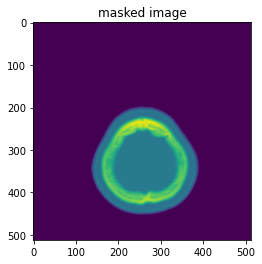

In [9]:
# put the head mask on the image

output_img = img_hu.copy()

for x in range (0, brainmask.shape[0]):
    for y in range (0, brainmask.shape[1]):
        if brainmask[x, y]==0:
            output_img[x, y] = -995
            
plt.imshow(output_img)
plt.title('masked image')
plt.show()

In [10]:
# put the performed above actions into pipeline

def removing_background_pipeline(dcm_path):
    
    img_hu = read_dicom_to_hu(dcm_path)
    label_image = label(masking(img_hu, 2800, 600))
    connected_regions = regionprops(label_image)
    brainmask = (label_image==(1+np.argmax([i.area for i in connected_regions]))).astype(int)
    
    output_img = img_hu.copy()

    for x in range (0, brainmask.shape[0]):
        for y in range (0, brainmask.shape[1]):
            if brainmask[x, y]==0:
                output_img[x, y] = -995
                
    return output_img

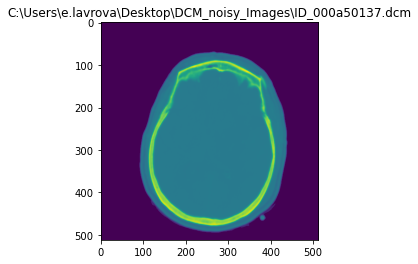

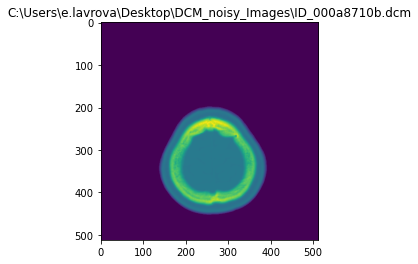

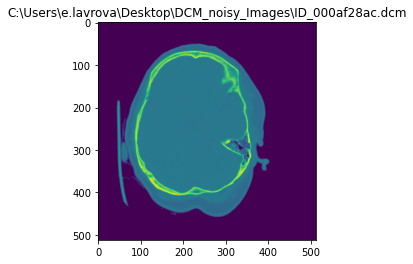

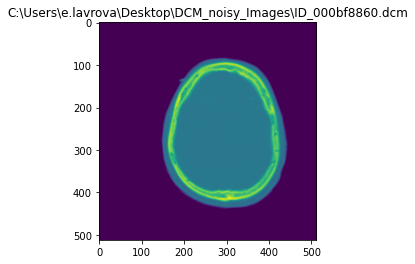

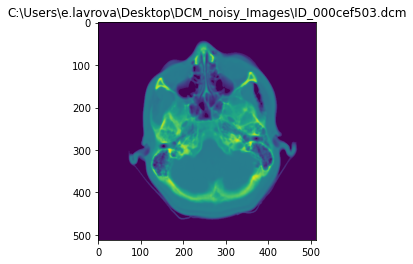

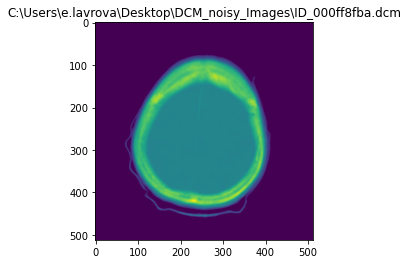

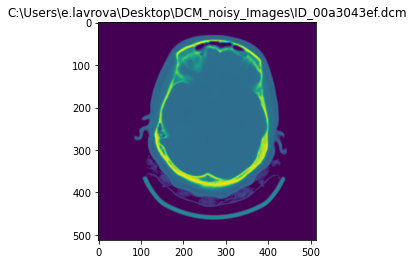

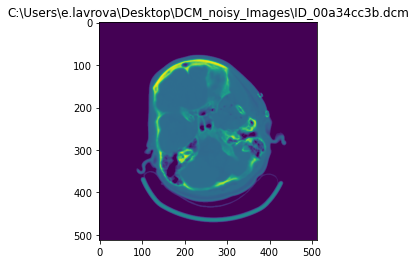

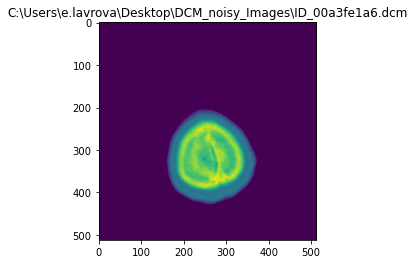

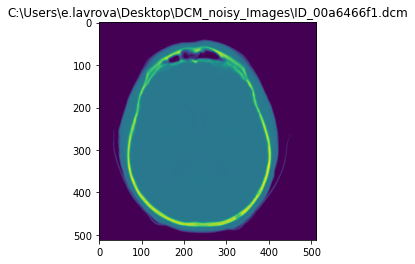

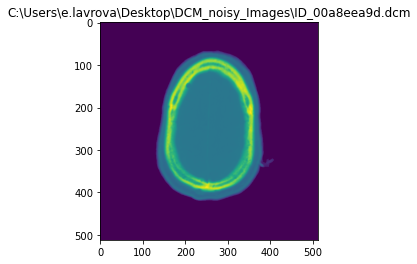

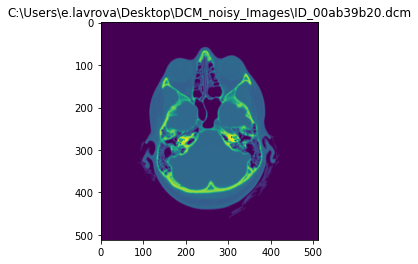

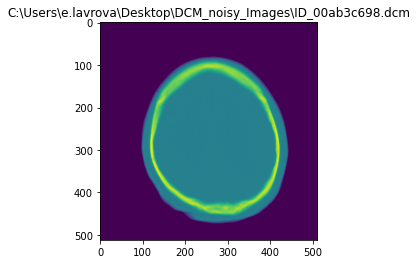

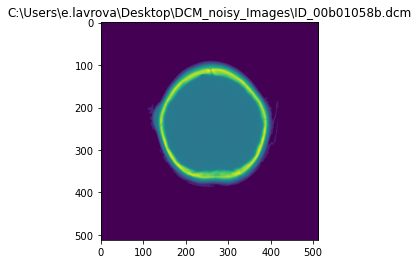

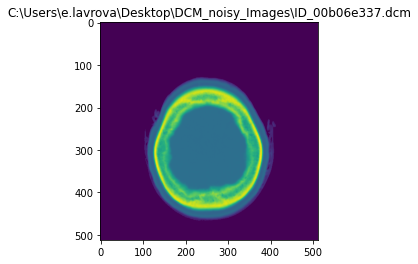

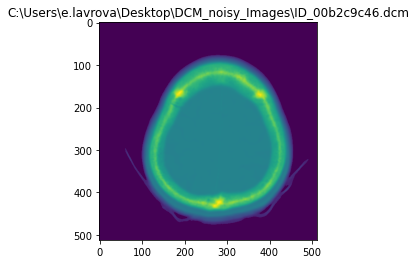

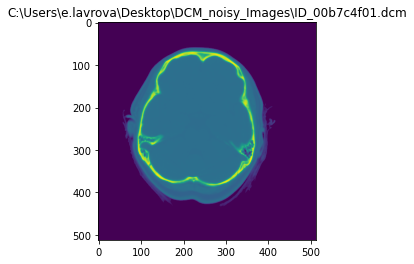

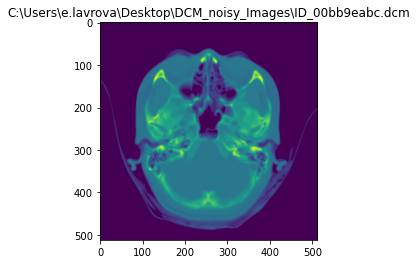

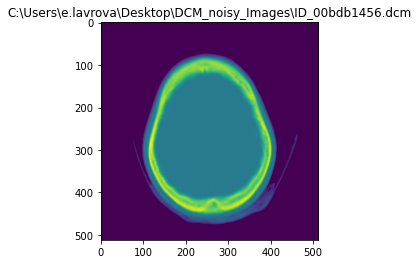

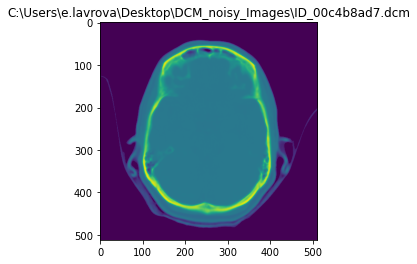

In [11]:
# check it with the other images in the folder

dirpath = r"C:\Users\e.lavrova\Desktop\DCM_noisy_Images"

for item in os.listdir(dirpath):
    path = os.path.join(dirpath, item)
    if item[-3:] == 'dcm':
        img_tmp = removing_background_pipeline(path)
        plt.imshow(img_tmp)
        plt.title(path)
        plt.show()